In [36]:
import sys
import torch
from matplotlib import pyplot as plt
import numpy as np

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

folder_path = '../data/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from pemp import PEMP
from cnmp import CNMP

from data_generators import *
from positional_encoders import *
from plotters import *


torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
#        gpu_util.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device :", device)

Device : cuda:0


In [37]:
dx, dy, dg, dpe = 1, 1, 0, 10
num_demos, num_val = 8, 2
num_trajs = num_demos + num_val
t_steps = 200
n_max, m_max = 10, 10
num_peaks = 3

# x, y, pp = n_peaks(1, num_trajs, 0.1)
x, y, pp = n_peaks(num_peaks, num_trajs, 0.05)

val_ids = []
while len(val_ids) < num_val:
    val_id = np.random.choice(np.arange(num_trajs), 1)
    # continue if pp[val_id] is either smallest or largest value
    # append to val_id otherwise
    if (pp[val_id, 0] == torch.max(pp[:,0 ]) or pp[val_id, 0] == torch.min(pp[:, 0])):
        continue
    else:
        if val_id not in val_ids:
            val_ids.append(val_id)

train_ids = np.setdiff1d(np.arange(num_trajs), val_ids)
val_ids = torch.tensor(val_ids).squeeze(-1)
train_ids = torch.from_numpy(train_ids)

test_cond_ind = (pp[val_ids] * 200).int()

y_train = y[train_ids].clone()
y_val = y[val_ids].clone()

x_train = x[train_ids].clone()
x_val = x[val_ids].clone()

# Print shapes
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")

x_train shape: torch.Size([8, 200, 1]), y_train shape: torch.Size([8, 200, 1])
x_val shape: torch.Size([2, 200, 1]), y_val shape: torch.Size([2, 200, 1])


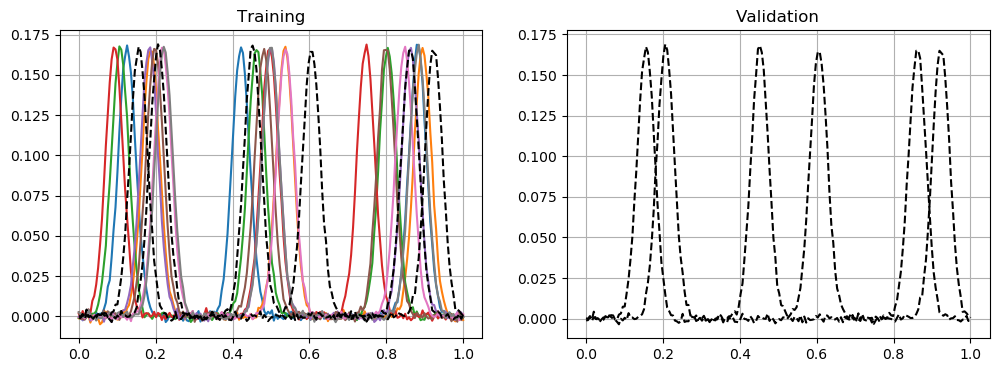

In [38]:
plot_train_val(num_demos, x_train, y_train, num_val, x_val, y_val)

In [39]:
batch_size = 1

enc_dims = [64,64]
dec_dims = [64,64]

pemp_ = PEMP(input_dim=dpe+dg, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)
optimizer = torch.optim.Adam(lr=3e-4, params=pemp_.parameters())

pemp_1 = PEMP(input_dim=dpe+dg, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)
optimizer1 = torch.optim.Adam(lr=3e-4, params=pemp_1.parameters())

cnmp_ = CNMP(input_dim=dx+dg, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)
optimizer_cnmp = torch.optim.Adam(lr=3e-4, params=cnmp_.parameters())

pytorch_total_params = sum(p.numel() for p in pemp_.parameters())
print('PEMP: ', pytorch_total_params)
pytorch_total_params = sum(p.numel() for p in cnmp_.parameters())
print('CNMP: ', pytorch_total_params)


if torch.__version__ >= "2.0":
    pemp, pemp1, cnmp = torch.compile(pemp_), torch.compile(pemp_1), torch.compile(cnmp_)
else:
    pemp, pemp1, cnmp = pemp_, pemp_1, cnmp_

PEMP:  9858
CNMP:  8706


In [40]:
d_model = dpe
pe_code = 0
pe = pes[pe_code]() / d_model

pe_code = 1
pe1 = pes[pe_code]() / d_model

# pe = generate_positional_encoding(1000, 256)

# import matplotlib.pyplot as plt
# plt.imshow(pe.T, cmap=plt.get_cmap('gray'))
# plt.show()

# print(pe)

In [41]:
dpe_aug = dpe + dg  # dg for gamma (peak_positions)
dpe_aug_cnmp = dx + dg

obs = torch.zeros((batch_size, n_max, dpe_aug+dy), dtype=torch.float32, device=device)
obs1 = torch.zeros((batch_size, n_max, dpe_aug+dy), dtype=torch.float32, device=device)
obs_cnmp = torch.zeros((batch_size, n_max, dpe_aug_cnmp+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dpe_aug), dtype=torch.float32, device=device)
tar_x1 = torch.zeros((batch_size, m_max, dpe_aug), dtype=torch.float32, device=device)
tar_x_cnmp = torch.zeros((batch_size, m_max, dpe_aug_cnmp), dtype=torch.float32, device=device)
tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    obs_cnmp.fill_(0)
    tar_x_cnmp.fill_(0)

    obs1.fill_(0)
    tar_x1.fill_(0)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(5, n_max, (1,)).item()
        m = torch.randint(1, m_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]
        
        obs[i, :n, :dpe] = pe[n_ids] # PE(t)
        obs[i, :n, dpe_aug:] = traj[n_ids]  # SM(t)
        obs_mask[i, :n] = True
        
        tar_x[i, :m, :dpe] = pe[m_ids]
        tar_y[i, :m] = traj[m_ids]
        tar_mask[i, :m] = True

        obs1[i, :n, :dpe] = pe1[n_ids] # PE(t)
        obs1[i, :n, dpe_aug:] = traj[n_ids]  # SM(t)

        tar_x1[i, :m, :dpe] = pe1[m_ids]

        obs_cnmp[i, :n, :dx] = x_train[traj_id, n_ids]
        obs_cnmp[i, :n, dpe_aug_cnmp:] = traj[n_ids]  # SM(t)
        tar_x_cnmp[i, :m, :dx] = x_train[traj_id, m_ids]

val_obs = torch.zeros((batch_size, n_max, dpe_aug+dy), dtype=torch.float32, device=device)
val_obs1 = torch.zeros((batch_size, n_max, dpe_aug+dy), dtype=torch.float32, device=device)
val_obs_cnmp = torch.zeros((batch_size, n_max, dpe_aug_cnmp+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dpe_aug), dtype=torch.float32, device=device)
val_tar_x1 = torch.zeros((batch_size, t_steps, dpe_aug), dtype=torch.float32, device=device)
val_tar_x_cnmp = torch.zeros((batch_size, t_steps, dpe_aug_cnmp), dtype=torch.float32, device=device)
val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

def prepare_masked_val_batch(t: list, traj_ids: list, fixed_ind=None):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)
    val_obs_mask.fill_(False)

    val_obs_cnmp.fill_(0)
    val_tar_x_cnmp.fill_(0)

    val_obs1.fill_(0)
    val_tar_x1.fill_(0)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = num_peaks #torch.randint(5, n_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)
        if fixed_ind != None:
            for p in range(n):
                n_ids[p] = fixed_ind[i, p]
            # n_ids[-1] = fixed_ind[i]
        
        val_obs[i, :n, :dpe] = pe[n_ids]
        val_obs[i, :n, dpe_aug:] = traj[n_ids]
        val_obs_mask[i, :n] = True

        val_obs1[i, :n, :dpe] = pe1[n_ids]
        val_obs1[i, :n, dpe_aug:] = traj[n_ids]
        
        val_tar_x[i, :, :dpe] = pe
        val_tar_y[i] = traj[m_ids]

        val_tar_x1[i, :, :dpe] = pe1

        val_obs_cnmp[i, :n, :dx] = x_train[traj_id, n_ids]
        val_obs_cnmp[i, :n, dpe_aug_cnmp:] = traj[n_ids]

        val_tar_x_cnmp[i, :, :dx] = x_train[traj_id]

In [42]:
import time
import os

pose_code = ('no' if dpe_aug==dpe else 'with') + '_pos'
arch_code = str(num_demos) + '_' + str(num_val) + '_'
for i in enc_dims:
    arch_code += str(i) + '_'
arch_code = arch_code[:-1]

timestamp = int(time.time())
root_folder = f'../outputs/comparison/{num_peaks}_peak/{pose_code}/{arch_code}/bs_{batch_size}/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

img_folder = f'{root_folder}img/'
if not os.path.exists(img_folder):
    os.makedirs(img_folder)

torch.save(y_train, f'{root_folder}y.pt')

epochs = 250_000
epoch_iter = num_demos // batch_size
v_epoch_iter = num_val//batch_size
avg_loss, avg_loss1, avg_loss_cnmp = 0, 0, 0
loss_report_interval = 500
val_per_epoch = 1000
min_val_loss, min_val_loss1, min_val_loss_cnmp = 1000000, 1000000, 1000000
mse_loss = torch.nn.MSELoss()

plot_validation = True

l, l1, l_cnmp = [], [], []

for epoch in range(epochs):
    epoch_loss, epoch_loss1, epoch_loss_cnmp = 0, 0, 0

    traj_ids = torch.randperm(num_demos)[:batch_size * epoch_iter].chunk(epoch_iter)

    for i in range(epoch_iter):
        prepare_masked_batch(y_train, traj_ids[i])

        optimizer.zero_grad()        
        pred = pemp(obs, tar_x, obs_mask)
        loss = pemp.loss(pred, tar_y, tar_mask)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        optimizer1.zero_grad()        
        pred1 = pemp1(obs1, tar_x1, obs_mask)
        loss1 = pemp1.loss(pred1, tar_y, tar_mask)
        loss1.backward()
        optimizer1.step()

        epoch_loss1 += loss1.item()

        optimizer_cnmp.zero_grad()        
        pred_cnmp = cnmp(obs_cnmp, tar_x_cnmp, obs_mask)
        loss_cnmp = cnmp.loss(pred_cnmp, tar_y, tar_mask)
        loss_cnmp.backward()
        optimizer_cnmp.step()

        epoch_loss_cnmp += loss_cnmp.item()

    if epoch % val_per_epoch == 0 and epoch > 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(num_val)[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_loss, val_loss1, val_loss_cnmp = 0, 0, 0

            for j in range(v_epoch_iter):
                prepare_masked_val_batch(y_val, v_traj_ids[j], test_cond_ind[v_traj_ids[j]])

                pred = pemp.val(val_obs, val_tar_x, val_obs_mask)
                if plot_validation:
                    for k in range(batch_size):
                        plt.plot(val_tar_y[k, :, 0].cpu().numpy(), label=f"True {k}")
                        plt.plot(pred[k, :, 0].cpu().numpy(), label=f"Pred {k}")
                        
                        plt.legend()
                        plt.savefig(f'{img_folder}{epoch}_PEMP_{j}_{k}.png')
                        plt.clf()
                val_loss += mse_loss(pred[:, :, :pemp.output_dim], val_tar_y).item()

                pred1 = pemp1.val(val_obs1, val_tar_x1, val_obs_mask)
                if plot_validation:
                    for k in range(batch_size):
                        plt.plot(val_tar_y[k, :, 0].cpu().numpy(), label=f"True {k}")
                        plt.plot(pred1[k, :, 0].cpu().numpy(), label=f"Pred {k}")
                        
                        plt.legend()
                        plt.savefig(f'{img_folder}{epoch}_PEMP1_{j}_{k}.png')
                        plt.clf()
                val_loss1 += mse_loss(pred1[:, :, :pemp1.output_dim], val_tar_y).item()

                pred_cnmp = cnmp.val(val_obs_cnmp, val_tar_x_cnmp, val_obs_mask)
                if plot_validation:
                    for k in range(batch_size):
                        plt.plot(val_tar_y[k, :, 0].cpu().numpy(), label=f"True {k}")
                        plt.plot(pred_cnmp[k, :, 0].cpu().numpy(), label=f"Pred {k}")
                        
                        plt.legend()
                        plt.savefig(f'{img_folder}{epoch}_CNMP_{j}_{k}.png')
                        plt.clf()
                val_loss_cnmp += mse_loss(pred_cnmp[:, :, :cnmp.output_dim], val_tar_y).item()
            
            val_loss /= v_epoch_iter
            val_loss1 /= v_epoch_iter
            val_loss_cnmp /= v_epoch_iter
                
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                print(f'PEMP New best: {min_val_loss}', f'CNMP best: {min_val_loss_cnmp}')
                torch.save(pemp_.state_dict(), f'{root_folder}saved_models/pemp.pt')

            if val_loss1 < min_val_loss1:
                min_val_loss1 = val_loss1
                # print(f'PEMP1 New best: {min_val_loss1}')
                torch.save(pemp_1.state_dict(), f'{root_folder}saved_models/pemp1.pt')

            if val_loss_cnmp < min_val_loss_cnmp:
                min_val_loss_cnmp = val_loss_cnmp
                print(f'CNMP New best: {min_val_loss_cnmp}', f'PEMP best: {min_val_loss}')
                torch.save(cnmp_.state_dict(), f'{root_folder}saved_models/cnmp.pt')

    epoch_loss /= epoch_iter
    epoch_loss1 /= epoch_iter
    epoch_loss_cnmp /= epoch_iter

    avg_loss += epoch_loss
    avg_loss1 += epoch_loss1
    avg_loss_cnmp += epoch_loss_cnmp

    l.append(epoch_loss)
    l1.append(epoch_loss1)
    l_cnmp.append(epoch_loss_cnmp)

    if epoch % loss_report_interval == 0:
        print("Epoch: {}, PEMP Loss: {}, PEMP1 Loss: {}, CNMP Loss: {}".format(epoch, avg_loss/loss_report_interval, avg_loss1/loss_report_interval, avg_loss_cnmp/loss_report_interval))
        avg_loss, avg_loss1, avg_loss_cnmp = 0, 0, 0

Epoch: 0, PEMP Loss: 0.0009992176815867425, PEMP1 Loss: 0.000921368770301342, CNMP Loss: 0.0011045055091381073
Epoch: 500, PEMP Loss: -1.4853541099464056, PEMP1 Loss: -1.4882360628525493, CNMP Loss: -1.4801367370602674
PEMP New best: 0.002644880674779415
PEMP1 New best: 0.0026290036039426923
CNMP New best: 0.0025859777815639973
Epoch: 1000, PEMP Loss: -1.5341308835155796, PEMP1 Loss: -1.542130767533672, CNMP Loss: -1.5272184444062877
Epoch: 1500, PEMP Loss: -1.5310260794193018, PEMP1 Loss: -1.5404159135427327, CNMP Loss: -1.525103926426964
Epoch: 2000, PEMP Loss: -1.5317436792110093, PEMP1 Loss: -1.5347908990005963, CNMP Loss: -1.5208148571327256
Epoch: 2500, PEMP Loss: -1.5403141832002438, PEMP1 Loss: -1.5444783499725163, CNMP Loss: -1.5280826815636828
Epoch: 3000, PEMP Loss: -1.5492951477630996, PEMP1 Loss: -1.5532929275698262, CNMP Loss: -1.5377908769678323
Epoch: 3500, PEMP Loss: -1.5316077649747022, PEMP1 Loss: -1.5399488446102478, CNMP Loss: -1.522214523980394
Epoch: 4000, PEMP L

In [ ]:
torch.save(l, f'{root_folder}losses.pt')
torch.save(l1, f'{root_folder}losses1.pt')
torch.save(l_cnmp, f'{root_folder}losses_cnmp.pt')